In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("data/spy_data.csv")
df = df.drop(df.index[[0,1]])
df = df.rename(columns={"Price" : "Date"})
df["Date"] = pd.to_datetime(df["Date"])
for col in df.select_dtypes(include="object").columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [31]:
df.head()

,Date,Close,High,Low,Open,Volume
2,2015-01-02,171.093643,172.301295,170.052573,171.884867,121465900
3,2015-01-05,168.003769,170.210833,167.695616,170.044264,169632600
4,2015-01-06,166.421371,168.836650,165.621824,168.311946,209151400
5,2015-01-07,168.495163,168.836637,167.304185,167.753921,125346700
6,2015-01-08,171.485153,171.701704,169.894407,169.911055,147217800


In [32]:
df.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [159]:
def test_dca(df, interval, invest_monthly):
    df = df.copy()

    # some checking
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop = True)

    # strategy here is about investing only on mondays 
    mondays = df[df["Date"].dt.day_name() == "Monday"].copy()
    mondays = mondays.iloc[::interval, :]

    amount_per_invest = invest_monthly / (4.33 / interval)

    # simulations
    mondays["Shares"] = amount_per_invest / mondays["Close"] # to know the share of the EFT one's can buy at this time
    mondays["Cumulative_shares"] = mondays["Shares"].cumsum()
    mondays["Total_invested"] = amount_per_invest * np.arange(1, len(mondays) + 1)
    mondays["Portfolio_value"] = mondays["Cumulative_shares"] * mondays["Close"]

    # some stats
    total_invested = mondays["Total_invested"].iloc[-1]
    final_value = mondays["Portfolio_value"].iloc[-1]
    total_return = (final_value - total_invested) / total_invested * 100
    returns = mondays["Portfolio_value"].pct_change().dropna()
    sharpe = np.sqrt(12) * (returns.mean() / returns.std()) if len(returns) > 2 else np.nan

    # lump sum
    first_price = mondays["Close"].iloc[0]             
    shares_bought = total_invested / first_price         

    mondays["LumpSum_Value"] = shares_bought * mondays["Close"]  
    final_lump_value = mondays["LumpSum_Value"].iloc[-1]
    total_return_lump = (final_lump_value - total_invested) / total_invested * 100

    returns_lump = mondays["LumpSum_Value"].pct_change().dropna()

    sharpe_lump = np.sqrt(12) * (returns_lump.mean() / returns_lump.std()) if len(returns_lump) > 2 else np.nan

    return {
        "interval_weeks": interval,
        "amount_per_invest": amount_per_invest,
        "total_invested": total_invested,
        "final_value": final_value,
        "total_return": total_return,
        "lump_value": final_lump_value,
        "lump_return": total_return_lump,
        "sharpe": sharpe,
        "sharpe_lump": sharpe_lump,
        "timeline": mondays
    }

In [169]:
results = []
for w in [1, 2, 4]:
    res = test_dca(df, interval = w, invest_monthly = 1000)
    results.append(res)

summary = pd.DataFrame([
    {
        "Investment": f"each {r['interval_weeks']} monday",
        "Buying (€)": round(r["amount_per_invest"], 2),
        "Total invested (€)": round(r["total_invested"], 2),
        "Final value of the portfolio DCA (€)": round(r["final_value"], 2),
        "Returns DCA (%)": round(r["total_return"], 2),
        "Sharpe DCA": round(r["sharpe"], 2),
    }
    for r in results
])
print(summary)


      Investment  Buying (€)  Total invested (€)  \
0  each 1 monday      230.95            97228.64   
1  each 2 monday      461.89            97459.58   
2  each 4 monday      923.79            97921.48   

   Final value of the portfolio DCA (€)  Returns DCA (%)  Sharpe DCA  
0                             174210.54            79.18        0.92  
1                             174812.92            79.37        1.20  
2                             175494.69            79.22        1.58  


In [164]:
lump_data = results[0]

summary_lump = pd.DataFrame([{
    "Initial investment": "Lump-Sum",
    "Total invested (€)": round(lump_data["total_invested"], 2),
    "Final value of the portfolio (€)": round(lump_data["lump_value"], 2),
    "Return (%)": round(lump_data["lump_return"], 2),
    "Sharpe ratio": round(lump_data["sharpe_lump"], 2)
}])

print(summary_lump)

  Initial investment  Total invested (€)  Final value of the portfolio (€)  \
0           Lump-Sum            97228.64                         267340.84   

   Return (%)  Sharpe ratio  
0      174.96          0.37  


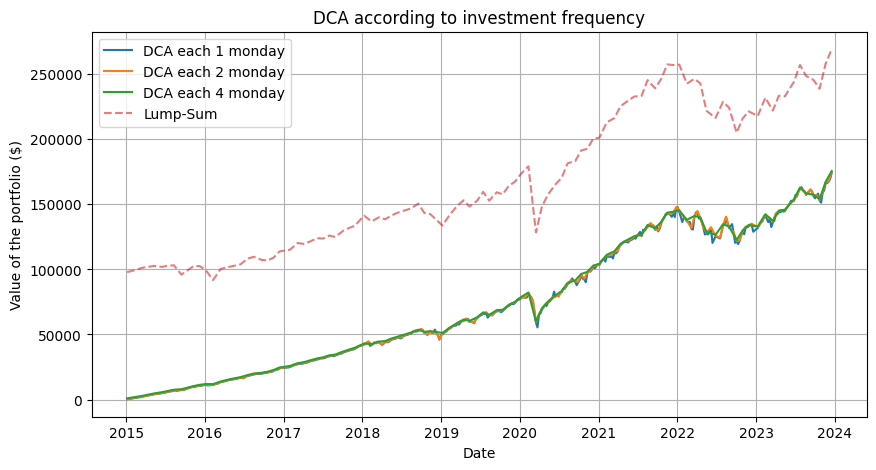

In [158]:
plt.figure(figsize=(10,5))
for r in results:
    plt.plot(r["timeline"]["Date"], r["timeline"]["Portfolio_value"], 
                label=f"DCA each {r['interval_weeks']} monday")
plt.plot(r["timeline"]["Date"], r["timeline"]["LumpSum_Value"], 
             linestyle="--", alpha=0.6, label=f"Lump-Sum")
plt.grid()
plt.title("DCA according to investment frequency")
plt.xlabel("Date")
plt.ylabel("Value of the portfolio ($)")
plt.legend()
plt.show()